### **Import required Libraries**



In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input


### **Load the data :**

In [2]:
data_dir = '/content/drive/MyDrive/LetsUpgradeProject'
covid_image_dir = '/content/drive/MyDrive/LetsUpgradeProject/COVID'
non_covid_image_dir = '/content/drive/MyDrive/LetsUpgradeProject/non-COVID'

In [3]:
print(f'Number of COVID Images: {len(os.listdir(covid_image_dir))} \nNumber of Non-COVID Images: {len(os.listdir(non_covid_image_dir))}')

Number of COVID Images: 1252 
Number of Non-COVID Images: 1231


### **The images are in different sizes so you have to take a fixed size on which you have to work.**

In [4]:
def resize_images(input_dir, output_dir, width=224, height=224):

  if not os.path.exists(output_dir):
    os.mkdir(output_dir)

  for filename in os.listdir(input_dir):
    image = Image.open(os.path.join(input_dir, filename))
    image = image.resize((width, height), Image.ANTIALIAS)
    image.save(os.path.join(output_dir, filename))

In [5]:
covid_input_dir = covid_image_dir
covid_output_dir = "/content/drive/MyDrive/LetsUpgradeProject/covid-resized/"
resize_images(covid_input_dir, covid_output_dir, width=224, height=224)

<ipython-input-4-3d68416def98>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((width, height), Image.ANTIALIAS)


In [6]:
print(f'Number of resize COVID Images: {len(os.listdir(covid_output_dir))}')

Number of resize COVID Images: 1252


In [7]:
non_covid_input_dir = non_covid_image_dir
non_covid_output_dir = "/content/drive/MyDrive/LetsUpgradeProject/non-covid-resized/"
resize_images(non_covid_input_dir, non_covid_output_dir, width=224, height=224)


<ipython-input-4-3d68416def98>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((width, height), Image.ANTIALIAS)


In [8]:
print(f'Number of resize Non-COVID Images: {len(os.listdir(non_covid_output_dir))}')

Number of resize Non-COVID Images: 1231


### **Storing resized images in a list**

In [9]:
covid_dir = os.listdir(covid_output_dir)
non_covid_dir = os.listdir(non_covid_output_dir)

### **Creating required folders**

In [10]:
if not os.path.exists("/content/drive/MyDrive/LetsUpgradeProject/data"):
    os.mkdir("/content/drive/MyDrive/LetsUpgradeProject/data")

if not os.path.exists("/content/drive/MyDrive/LetsUpgradeProject/data/Train"):
    os.mkdir("/content/drive/MyDrive/LetsUpgradeProject/data/Train")

if not os.path.exists("/content/drive/MyDrive/LetsUpgradeProject/data/Train/Covid"):
    os.mkdir("/content/drive/MyDrive/LetsUpgradeProject/data/Train/Covid")

if not os.path.exists("/content/drive/MyDrive/LetsUpgradeProject/data/Train/Non-Covid"):
    os.mkdir("/content/drive/MyDrive/LetsUpgradeProject/data/Train/Non-Covid")

if not os.path.exists("/content/drive/MyDrive/LetsUpgradeProject/data/Test"):
    os.mkdir("/content/drive/MyDrive/LetsUpgradeProject/data/Test")

if not os.path.exists("/content/drive/MyDrive/LetsUpgradeProject/data/Test/Covid"):
    os.mkdir("/content/drive/MyDrive/LetsUpgradeProject/data/Test/Covid")

if not os.path.exists("/content/drive/MyDrive/LetsUpgradeProject/data/Test/Non-Covid"):
    os.mkdir("/content/drive/MyDrive/LetsUpgradeProject/data/Test/Non-Covid")


### **Dividing covid images in train and test folders.**

In [11]:
train_covid, test_covid = train_test_split(covid_dir, test_size=0.25, random_state=1)

train_covid_folder_path = "/content/drive/MyDrive/LetsUpgradeProject/data/Train/Covid"
test_covid_folder_path = "/content/drive/MyDrive/LetsUpgradeProject/data/Test/Covid"

for file in train_covid:
    shutil.copy(os.path.join(covid_output_dir, file), train_covid_folder_path)

for file in test_covid:
    shutil.copy(os.path.join(covid_output_dir, file), test_covid_folder_path)

len(os.listdir(train_covid_folder_path)), len(os.listdir(test_covid_folder_path))

(939, 313)

### **Dividing non-covid images in train and test folders.**

In [12]:
train_non_covid, test_non_covid = train_test_split(non_covid_dir, test_size=0.25, random_state=1)

train_non_covid_folder_path = "/content/drive/MyDrive/LetsUpgradeProject/data/Train/Non-Covid"
test_non_covid_folder_path = "/content/drive/MyDrive/LetsUpgradeProject/data/Test/Non-Covid"

for file in train_non_covid:
    shutil.copy(os.path.join(non_covid_output_dir, file), train_non_covid_folder_path)

for file in test_non_covid:
    shutil.copy(os.path.join(non_covid_output_dir, file), test_non_covid_folder_path)

len(os.listdir(train_non_covid_folder_path)), len(os.listdir(test_non_covid_folder_path))

(923, 308)

### **Using ResNet-50 Pretrained Moldel**

In [13]:
IMAGE_SIZE = [224,224]

train_path = "/content/drive/MyDrive/LetsUpgradeProject/data/Train"
test_path = "/content/drive/MyDrive/LetsUpgradeProject/data/Test"

resnet = ResNet50(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#Now we dont have to train the existing weights we just have to train our last layer.
for layer in resnet.layers:
  layer.trainable = False

#By using the Glob function we will be able to know our output classes.
folder = glob('/content/drive/MyDrive/LetsUpgradeProject/data/*')
folder

#Flatten our ResNet model.
x = Flatten()(resnet.output)

#Adding our last layer
prediction = Dense(2, activation='softmax')(x)

model = Model(inputs = resnet.inputs, outputs = prediction)


94765736/94765736 [==============================] - 1s 0us/step


In [14]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
##Compiling our model
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### **Data Augmentation**
##### Scaling all the images between 0 to 1


In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False, width_shift_range=0.1,height_shift_range=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

# flow_from_directory means i am applying all the train_datagen techniques to all the images
# If you have more than two classes we should use class_mode = categorical

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode = 'categorical')

# Applying the same techniques on the test dataset
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 1862 images belonging to 2 classes.
Found 621 images belonging to 2 classes.


In [18]:
Early_Stopping = EarlyStopping(monitor='val_loss', patience=5 , mode='min', verbose=1)
model_checkpoint = ModelCheckpoint('resnet50.h5', save_best_only=True)


In [19]:
history = model.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set), callbacks=[Early_Stopping, model_checkpoint])

Epoch 1/50
59/59 [==============================] - 59s 776ms/step - loss: 2.1884 - accuracy: 0.5462 - val_loss: 0.6517 - val_accuracy: 0.6747
Epoch 2/50
59/59 [==============================] - 40s 676ms/step - loss: 0.6278 - accuracy: 0.6638 - val_loss: 0.8497 - val_accuracy: 0.6264
Epoch 3/50
59/59 [==============================] - 48s 812ms/step - loss: 0.6497 - accuracy: 0.6810 - val_loss: 0.5946 - val_accuracy: 0.7053
Epoch 4/50
59/59 [==============================] - 41s 703ms/step - loss: 0.6037 - accuracy: 0.6917 - val_loss: 0.5212 - val_accuracy: 0.7536
Epoch 5/50
59/59 [==============================] - 42s 710ms/step - loss: 0.7091 - accuracy: 0.6751 - val_loss: 0.6332 - val_accuracy: 0.7440
Epoch 6/50
59/59 [==============================] - 37s 632ms/step - loss: 0.5524 - accuracy: 0.7288 - val_loss: 0.5101 - val_accuracy: 0.7697
Epoch 7/50
59/59 [==============================] - 37s 629ms/step - loss: 0.6156 - accuracy: 0.7256 - val_loss: 0.4062 - val_accuracy: 0.8213

### **Plotting the result**

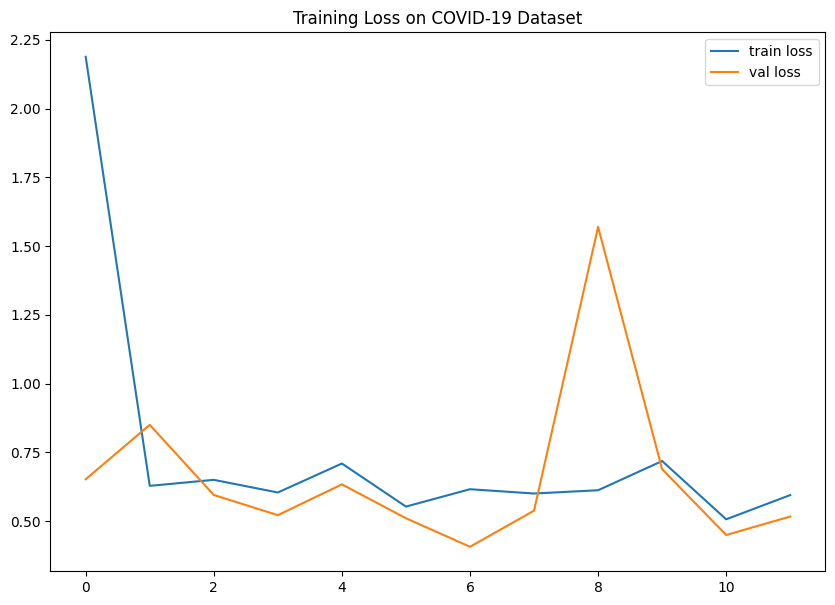

In [20]:
#Plotting the losses and Accuracy on the dataset

plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Training Loss on COVID-19 Dataset")
plt.legend()
plt.show()

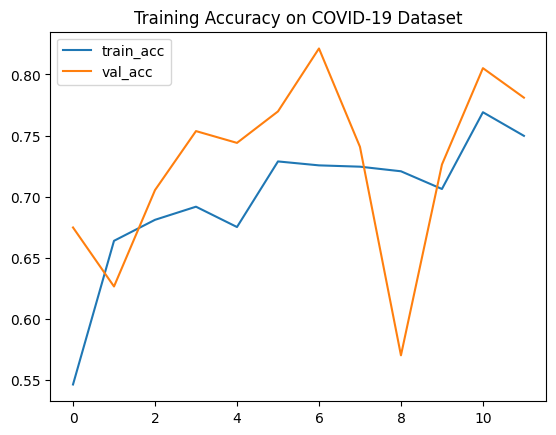

<Figure size 640x480 with 0 Axes>

In [21]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Training Accuracy on COVID-19 Dataset")
plt.legend()
plt.show()
plt.savefig('lossval_loss')

### **Saving Model**

In [28]:
#Saving the h5 file

model.save('covid_predicting_model.h5')

### **Prediction**

In [24]:
pred = model.predict(test_set)
pred

20/20 [==============================] - 4s 157ms/step


array([[0.34189132, 0.6581087 ],
       [0.53569806, 0.46430197],
       [0.9309549 , 0.06904513],
       ...,
       [0.3771723 , 0.62282765],
       [0.9975395 , 0.0024605 ],
       [0.15763952, 0.8423605 ]], dtype=float32)

In [26]:
pred = np.argmax(pred, axis=0)
pred

array([245, 176])

### **Loading our model**


In [29]:
model = load_model('covid_predicting_model.h5')


### **Predicting image class**

In [65]:
img1 = image.load_img('/content/drive/MyDrive/LetsUpgradeProject/data/Test/Non-Covid/Non-Covid (106).png', target_size=(224,224))


In [66]:
x1 = image.img_to_array(img1)
x1


array([[[ 60.,  60.,  60.],
        [ 63.,  63.,  63.],
        [ 60.,  60.,  60.],
        ...,
        [ 65.,  65.,  65.],
        [ 66.,  66.,  66.],
        [ 65.,  65.,  65.]],

       [[ 64.,  64.,  64.],
        [ 64.,  64.,  64.],
        [ 63.,  63.,  63.],
        ...,
        [ 67.,  67.,  67.],
        [ 75.,  75.,  75.],
        [ 69.,  69.,  69.]],

       [[ 57.,  57.,  57.],
        [ 56.,  56.,  56.],
        [119., 119., 119.],
        ...,
        [ 64.,  64.,  64.],
        [ 72.,  72.,  72.],
        [ 65.,  65.,  65.]],

       ...,

       [[252., 252., 252.],
        [255., 255., 255.],
        [248., 248., 248.],
        ...,
        [247., 247., 247.],
        [234., 234., 234.],
        [232., 232., 232.]],

       [[231., 231., 231.],
        [233., 233., 233.],
        [237., 237., 237.],
        ...,
        [215., 215., 215.],
        [218., 218., 218.],
        [226., 226., 226.]],

       [[212., 212., 212.],
        [217., 217., 217.],
        [218., 2

In [67]:
x1.shape,


((224, 224, 3),)

In [68]:
x1 = x1/255


In [69]:
x1=np.expand_dims(x1,axis=0)

img_data1=preprocess_input(x1)
img_data1.shape


(1, 224, 224, 3)

In [70]:
model.predict(img_data1)


1/1 [==============================] - 0s 26ms/step


array([[7.327902e-07, 9.999993e-01]], dtype=float32)

In [71]:
a1=np.argmax(model.predict(img_data1), axis=1)


1/1 [==============================] - 0s 52ms/step


In [72]:
def pred_img(a):
  if(a==1):
    print("The person does not have COVID-19")
  else:
    print("The person has COVID-19")



In [73]:
pred_img(a1)

The person does not have COVID-19
